In [24]:
# import nltk
# nltk.download("twitter_samples")

In [85]:
import re
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from nltk.corpus import twitter_samples

corpus = twitter_samples.strings("positive_tweets.json")
corpus = corpus + twitter_samples.strings("negative_tweets.json")

stopwords = nltk.corpus.stopwords.words("english")
lemmatizer = nltk.WordNetLemmatizer()


def simple_preprocessing(text):
    text = text.lower()
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"[\n\t]", " ", text)
    text = re.sub(r" +", " ", text)
    text = re.sub(r"[^a-z ]", "", text)

    tokens = nltk.TweetTokenizer().tokenize(text)
    tokens = [token for token in tokens if token not in stopwords and len(token) >= 3]
    lemmas = [lemmatizer.lemmatize(token) for token in tokens]
    return " ".join(lemmas)


corpus = [simple_preprocessing(text) for text in corpus]
corpus = [text for text in corpus if len(text) > 6]  # don't want random no-word posts
corpus = list(set(corpus))

In [86]:
corpus[:10]

['would love see dear jordan waiting',
 'july mean time give love mistgameplay iloveyou',
 'find major people except sure kept luminous didnt km',
 'many thanks via',
 'fuckkk wednesday',
 'come back',
 'gran tho knew didnt care tell',
 'shouldve asleep hour ago',
 'aur han imran khan still younger many',
 'know saying know']

In [87]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
print(X.toarray()[0:3])

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [88]:
X.shape

(8389, 10703)

In [89]:
import numpy as np
np.random.seed(0)

N_TOPICS = 5
svd = TruncatedSVD(n_components=N_TOPICS, random_state=0)
latent_semantic_analysis = svd.fit_transform(X)

terms = vectorizer.get_feature_names_out()
N_TERMS = 5
for i, comp in enumerate(svd.components_):
    terms_in_comp = zip(terms, comp)
    sorted_terms = sorted(terms_in_comp, key=lambda x:x[1], reverse=True)[:N_TERMS]
    print("Topic "+str(i)+": ")
    print("|".join([t for t, _ in sorted_terms]))
    print(" ")

Topic 0: 
thanks|day|good|dont|like
 
Topic 1: 
thanks|follow|please|great|following
 
Topic 2: 
follow|please|miss|dont|back
 
Topic 3: 
miss|much|thank|love|day
 
Topic 4: 
day|follow|please|love|thank
 


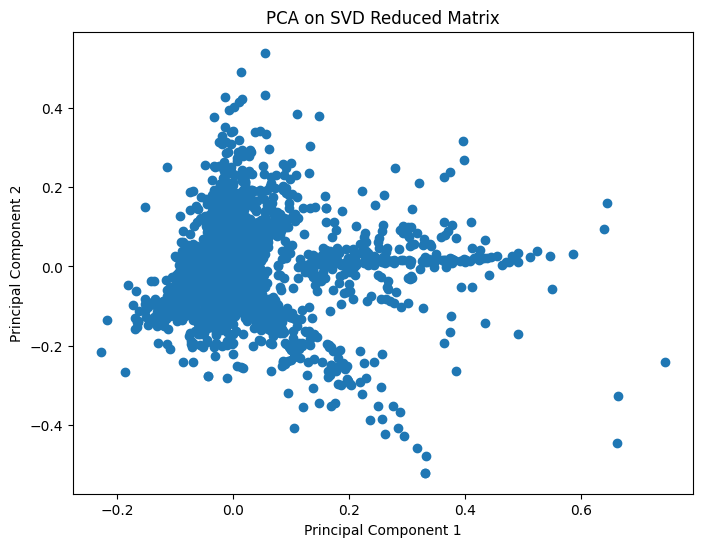

In [90]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Assume 'latent_semantic_analysis' is the reduced matrix from SVD
# latent_semantic_analysis = ...

# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(latent_semantic_analysis)

# Plot the result
plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA on SVD Reduced Matrix')
plt.show()


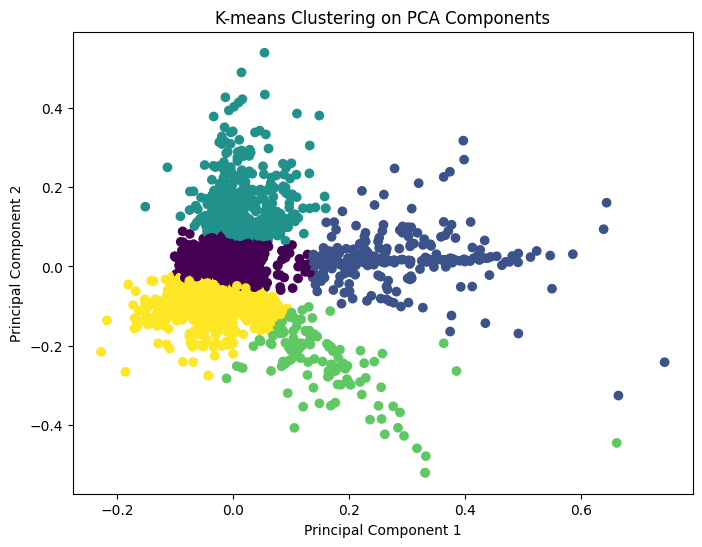

In [91]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=N_TOPICS)
kmeans.fit(pca_result)

# Get the cluster assignments
cluster_assignments = kmeans.labels_

# Plot the clusters
plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=cluster_assignments)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('K-means Clustering on PCA Components')
plt.show()


In [92]:
# inspect data from each cluster
for i in range(N_TOPICS):
    print(f"Cluster {i}")
    cluster_indices = np.where(cluster_assignments == i)[0]
    for j in cluster_indices[:5]:
        print(corpus[j])
    print("\n\n")

Cluster 0
find major people except sure kept luminous didnt km
fuckkk wednesday
gran tho knew didnt care tell
shouldve asleep hour ago
aur han imran khan still younger many



Cluster 1
many thanks via
like michael thanks kind word cheer
short stream tomorrow fun day today thanks
thanks tweeting
thanks zzz



Cluster 2
twas great thank
ive typed worse thing good
hey hope good day
thought best day paper town today
early day boner mercy



Cluster 3
come back
yesterday follow got neither
please follow back
beautiful follow please
please follow love much would mean world



Cluster 4
would love see dear jordan waiting
july mean time give love mistgameplay iloveyou
know saying know
wow miss long hair brace amp softball
know life want see picture parijat sad willmissyouparijat



